<a href="https://colab.research.google.com/github/sean-halpin/chess_website/blob/models_init/models/Chess_Eval_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Download

In [1]:
# https://database.lichess.org/standard/lichess_db_standard_rated_2013-01.pgn.zst

In [1]:
!pip install zstandard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 12.0 MB/s eta 0:00:00


In [2]:
import requests
import zstandard
import io

lichess = "https://database.lichess.org/standard/"
dbfile = "lichess_db_standard_rated_2017-01.pgn.zst"
url = lichess + dbfile
compressed_file_path = dbfile
output_path = dbfile.replace(".zst","")

# Download the Zstandard compressed file
response = requests.get(url)
if response.status_code == 200:
    with open(compressed_file_path, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded successfully to {compressed_file_path}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

# Extract the Zstandard compressed file
with open(compressed_file_path, 'rb') as compressed_file:
    dctx = zstandard.ZstdDecompressor()
    with dctx.stream_reader(compressed_file) as reader:
        with open(output_path, 'wb') as output:
            output.write(reader.read())

print(f"File extracted successfully to {output_path}")


File downloaded successfully to lichess_db_standard_rated_2017-01.pgn.zst
File extracted successfully to lichess_db_standard_rated_2017-01.pgn


# Data Exploration

In [3]:
!ls

lichess_db_standard_rated_2017-01.pgn  lichess_db_standard_rated_2017-01.pgn.zst  sample_data


In [4]:
!cat lichess_db_standard_rated_2017-01.pgn | grep '\[%eval' | wc -l

1235035


In [5]:
!cat lichess_db_standard_rated_2017-01.pgn | grep '\[%eval' | head -n5

1. e4 { [%eval 0.14] } 1... e5 { [%eval 0.16] } 2. Nf3 { [%eval 0.24] } 2... Nc6 { [%eval 0.31] } 3. Bc4 { [%eval 0.15] } 3... Nd4?! { [%eval 0.94] } 4. c3 { [%eval 0.57] } 4... Nxf3+ { [%eval 0.53] } 5. Qxf3 { [%eval 0.52] } 5... Qf6 { [%eval 0.55] } 6. Qe2 { [%eval 0.5] } 6... c6 { [%eval 0.67] } 7. d3 { [%eval 0.37] } 7... Bc5 { [%eval 0.47] } 8. O-O { [%eval 0.16] } 8... Ne7 { [%eval 0.24] } 9. Kh1 { [%eval 0.16] } 9... Ng6 { [%eval 0.17] } 10. g3?! { [%eval -0.71] } 10... O-O?! { [%eval 0.09] } 11. f4?! { [%eval -0.75] } 11... exf4?! { [%eval -0.19] } 12. gxf4?! { [%eval -0.72] } 12... d5 { [%eval -0.64] } 13. exd5? { [%eval -2.46] } 13... cxd5?! { [%eval -1.54] } 14. Bxd5 { [%eval -1.62] } 14... Be6? { [%eval 0.0] } 15. Bxe6 { [%eval -0.03] } 15... fxe6 { [%eval 0.0] } 16. d4 { [%eval 0.0] } 16... Bd6 { [%eval 0.0] } 17. Be3 { [%eval -0.17] } 17... Bxf4 { [%eval -0.08] } 18. Nd2 { [%eval -0.09] } 18... Qf5 { [%eval -0.07] } 19. Nc4?? { [%eval -3.79] } 19... Qd5+ { [%eval -3.64] }

In [6]:
!cat lichess_db_standard_rated_2017-01.pgn | grep '\[%eval' > lichess.pgn.eval

In [7]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00


# Data Visualisation

In [10]:
import chess.pgn
import re

pgn_text = """
1. e4 { [%eval 0.2] [%eval 0.2] } 1... e6 { [%eval 0.13] } 2. Bc4 { [%eval -0.31] } 2... d5 { [%eval -0.28] } 3. exd5 { [%eval -0.37] } 3... exd5 { [%eval -0.31] } 4. Bb3 { [%eval -0.33] } 4... Nf6 { [%eval -0.35] } 5. d4 { [%eval -0.34] } 5... Be7 { [%eval 0.0] } 6. Nf3 { [%eval 0.0] } 6... O-O { [%eval -0.08] } 7. Bg5 { [%eval -0.19] } 7... h6 { [%eval -0.29] } 8. Bxf6 { [%eval -0.36] } 8... Bxf6 { [%eval -0.37] } 9. O-O { [%eval -0.36] } 9... c6 { [%eval -0.12] } 10. Re1 { [%eval -0.17] } 10... Bf5 { [%eval -0.04] } 11. c4?! { [%eval -0.67] } 11... dxc4 { [%eval -0.5] } 12. Bxc4 { [%eval -0.77] } 12... Nd7?! { [%eval -0.1] } 13. Nc3 { [%eval 0.0] } 13... Nb6 { [%eval 0.0] } 14. b3?! { [%eval -0.76] } 14... Nxc4 { [%eval -0.49] } 15. bxc4 { [%eval -0.65] } 15... Qa5 { [%eval -0.55] } 16. Rc1 { [%eval -0.79] } 16... Rad8 { [%eval -0.78] } 17. d5?? { [%eval -5.41] } 17... Bxc3 { [%eval -5.42] } 18. Re5? { [%eval -7.61] } 18... Bxe5 { [%eval -7.78] } 19. Nxe5 { [%eval -7.72] } 19... cxd5 { [%eval -7.81] } 20. Qe1? { [%eval -9.29] } 20... Be6?? { [%eval 3.71] } 21. Rd1?? { [%eval -12.34] } 21... dxc4 { [%eval -12.71] } 22. Rxd8?! { [%eval #-1] } 22... Rxd8?! { [%eval -13.06] } 23. Qc3?! { [%eval #-2] } 23... Qxc3?! { [%eval #-4] } 24. g3 { [%eval #-3] } 24... Rd1+?! { [%eval #-4] } 25. Kg2 { [%eval #-4] } 25... Qe1?! { [%eval #-4] } 26. Kf3 { [%eval #-3] } 26... Qxe5 { [%eval #-2] } 27. Kg2 { [%eval #-2] } 27... Bd5+?! { [%eval #-2] } 28. Kh3 { [%eval #-1] } 28... Qh5# 0-1
"""

game = chess.pgn.read_game(io.StringIO(pgn_text))

board = game.board()
for node in list(game.mainline()):
    print()
    print(node.move)
    # print(node)
    print(node.comment)
    pattern = r"\[%eval\s+([#])*([\d.-]+)\]"
    match = re.search(pattern, node.comment)
    if match:
        print((match.group(1) if match.group(1) is not None else ""), match.group(2))
    else:
        print("No '%eval' found in the text.")
    board.push(node.move)
    print(board)
    checkMate = board.is_checkmate()
    print("Checkmate?", checkMate)
    i=0
    for square in chess.SQUARES:
      piece = board.piece_at(square)
      print(f"Square {chess.square_name(square)}: {piece}: {(board.piece_at(square).piece_type * (1 if board.piece_at(square).color else -1)) if piece is not None else 0}")



e2e4
[%eval 0.2] [%eval 0.2]
 0.2
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
Checkmate? False
Square a1: R: 4
Square b1: N: 2
Square c1: B: 3
Square d1: Q: 5
Square e1: K: 6
Square f1: B: 3
Square g1: N: 2
Square h1: R: 4
Square a2: P: 1
Square b2: P: 1
Square c2: P: 1
Square d2: P: 1
Square e2: None: 0
Square f2: P: 1
Square g2: P: 1
Square h2: P: 1
Square a3: None: 0
Square b3: None: 0
Square c3: None: 0
Square d3: None: 0
Square e3: None: 0
Square f3: None: 0
Square g3: None: 0
Square h3: None: 0
Square a4: None: 0
Square b4: None: 0
Square c4: None: 0
Square d4: None: 0
Square e4: P: 1
Square f4: None: 0
Square g4: None: 0
Square h4: None: 0
Square a5: None: 0
Square b5: None: 0
Square c5: None: 0
Square d5: None: 0
Square e5: None: 0
Square f5: None: 0
Square g5: None: 0
Square h5: None: 0
Square a6: None: 0
Square b6: None: 0
Square c6: None: 0
Square d6: None: 0
Square e6: None: 0
Square f6: No

In [13]:
abs(float('-2.0'))

2.0

In [70]:
import pandas as pd
rows_data = []
columns = []
for square in chess.SQUARES:
  piece = board.piece_at(square)
  columns.append(chess.square_name(square))
columns.append("eval")
columns.append("check_in")

i=0
with open('lichess.pgn.eval', 'r') as file:
    for pgn_text in file:
      # print(pgn_text)
      game = chess.pgn.read_game(io.StringIO(pgn_text))
      board = game.board()
      for node in list(game.mainline()):
          row_data = [(((board.piece_at(square).piece_type * (1 if board.piece_at(square).color else -1))) if board.piece_at(square) is not None else 0) for square in chess.SQUARES]
          pattern = r"\[%eval\s+([#])*([\d.-]+)\]"
          match = re.search(pattern, node.comment)
          if match:
            if match.group(1) is None:
              eval = f"{match.group(2)}"
              check_in = 0 #Integer.MAX_VALUE if board.piece_at(square).color else Integer.MIN_VALUE
            else:
              eval = 0
              if float(match.group(2)) > 0 and float(match.group(2)) <= 10:
                check_in = 10 - float(match.group(2))
              elif float(match.group(2)) < 0 and float(match.group(2)) >= -10:
                check_in = -10 + float(match.group(2))
              else:
                check_in = 0
          row_data.append(eval)
          row_data.append(check_in)
          rows_data.append(row_data)
          # move next
          board.push(node.move)
      i+=1
      if i % 1_000 == 0:
        print(i)
      if i >= 10_000:
        break

df = pd.DataFrame(rows_data, columns=columns)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [71]:
df

,a1,b1,c1,d1,e1,f1,g1,h1,a2,b2,...,a8,b8,c8,d8,e8,f8,g8,h8,eval,check_in
0,4,2,3,5,6,3,2,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,0.14,0.0
1,4,2,3,5,6,3,2,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,0.16,0.0
2,4,2,3,5,6,3,2,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,0.24,0.0
3,4,2,3,5,6,3,0,4,1,1,...,-4,-2,-3,-5,-6,-3,-2,-4,0.31,0.0
4,4,2,3,5,6,3,0,4,1,1,...,-4,0,-3,-5,-6,-3,-2,-4,0.15,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629195,4,0,0,5,6,3,0,4,1,1,...,0,-4,-3,-5,-6,0,0,-4,0.71,0.0
629196,4,0,0,5,6,3,0,4,1,1,...,0,-4,-3,-5,-6,0,0,-4,0,8.0
629197,4,0,0,5,6,3,0,4,1,1,...,0,-4,-3,-5,-6,0,0,-4,0,9.0
629198,4,0,0,0,6,3,0,4,1,1,...,0,-4,-3,-5,-6,0,0,-4,0,9.0


In [72]:
value_ranges = df.describe().loc[['min', 'max']]
print("Value Ranges:")
print(value_ranges)

Value Ranges:
      a1   b1   c1   d1   e1   f1   g1   h1   a2   b2  ...   h7   a8   b8  \
min -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0  ... -6.0 -6.0 -6.0   
max  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  ...  6.0  6.0  6.0   

      c8   d8   e8   f8   g8   h8  check_in  
min -6.0 -6.0 -6.0 -6.0 -6.0 -6.0     -20.0  
max  6.0  6.0  6.0  6.0  6.0  6.0       9.0  

[2 rows x 65 columns]


In [73]:
df.dtypes

a1            int64
b1            int64
c1            int64
d1            int64
e1            int64
             ...   
f8            int64
g8            int64
h8            int64
eval         object
check_in    float64
Length: 66, dtype: object

In [74]:
df['eval'] = df['eval'].astype(float)
df['check_in'] = df['check_in'].astype(float)

# Define Model

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc2z = nn.Linear(512, 512)
        self.fc2a = nn.Linear(512, 256)
        self.fc2b = nn.Linear(256, 128)
        self.fc3_eval = nn.Linear(128, 1)  # Output for 'eval'
        self.fc3_check_in = nn.Linear(128, 1)  # Output for 'check_in'

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc2z(x))
        x = torch.relu(self.fc2a(x))
        x = torch.relu(self.fc2b(x))
        eval_output = self.fc3_eval(x)
        check_in_output = self.fc3_check_in(x)
        return eval_output, check_in_output


In [90]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare the data
X = df.drop(columns=['eval', 'check_in']).values
y = df[['eval', 'check_in']].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the model and move it to GPU if available
input_dim = X_train.shape[1]
model = Net(input_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    eval_output, check_in_output = model(X_train_tensor)

    # Compute the loss for 'eval' output
    eval_loss = criterion(eval_output, y_train_tensor[:, 0].view(-1, 1))  # Assuming 'eval' is the first column

    # Compute the loss for 'check_in' output
    check_in_loss = criterion(check_in_output, y_train_tensor[:, 1].view(-1, 1))  # Assuming 'check_in' is the second column

    # Combine the losses (e.g., by summing)
    loss = eval_loss + check_in_loss

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
with torch.no_grad():
    eval_output, check_in_output = model(X_test_tensor)

    # Compute the loss for 'eval' output
    eval_loss = criterion(eval_output, y_test_tensor[:, 0].view(-1, 1))  # Assuming 'eval' is the first column

    # Compute the loss for 'check_in' output
    check_in_loss = criterion(check_in_output, y_test_tensor[:, 1].view(-1, 1))  # Assuming 'check_in' is the second column

    # Combine the losses (e.g., by summing)
    test_loss = eval_loss + check_in_loss

    print(f'Test Loss: {test_loss.item()}')


Epoch 1/500, Loss: 80.14366149902344
Epoch 11/500, Loss: 74.77487182617188
Epoch 21/500, Loss: 70.26876831054688
Epoch 31/500, Loss: 67.41154479980469
Epoch 41/500, Loss: 64.58525085449219
Epoch 51/500, Loss: 63.53805923461914
Epoch 61/500, Loss: 62.75969696044922
Epoch 71/500, Loss: 62.134849548339844
Epoch 81/500, Loss: 61.45793151855469
Epoch 91/500, Loss: 60.801273345947266
Epoch 101/500, Loss: 60.26020050048828
Epoch 111/500, Loss: 59.630096435546875
Epoch 121/500, Loss: 59.34107208251953
Epoch 131/500, Loss: 58.7076301574707
Epoch 141/500, Loss: 58.10041427612305
Epoch 151/500, Loss: 57.916175842285156
Epoch 161/500, Loss: 57.565643310546875
Epoch 171/500, Loss: 56.690635681152344
Epoch 181/500, Loss: 55.37818145751953
Epoch 191/500, Loss: 55.00555419921875
Epoch 201/500, Loss: 56.0306510925293
Epoch 211/500, Loss: 53.71164321899414


# Play Chess

In [78]:
def generate_pgn(board, moves):
    game = chess.pgn.Game()

    node = game
    for move in moves:
        node = node.add_variation(move)

    game.headers["Result"] = board.result()
    return str(game)

EVAL: 1.4486658573150635: -0.4725099205970764: a2a3: d2d3
a2a3
********************************* 



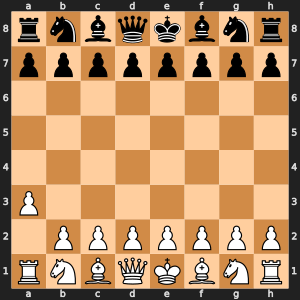

EVAL: 0.8748877644538879: -0.5611377358436584: d7d5: a7a5
d7d5
********************************* 



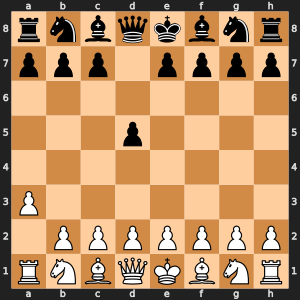

EVAL: 1.0549261569976807: -0.4250350594520569: b2b3: a1a2
b2b3
********************************* 



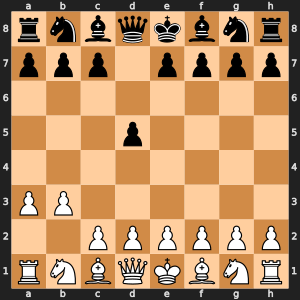

EVAL: 0.6930182576179504: -0.7005296349525452: b8c6: e8d7
b8c6
********************************* 



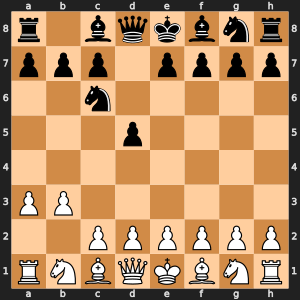

EVAL: 0.9080184102058411: -0.3851180672645569: a3a4: a1a2
a3a4
********************************* 



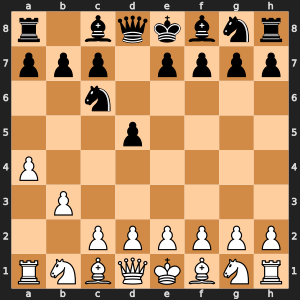

EVAL: 0.3503764271736145: -0.6411319375038147: c6e5: e8d7
c6e5
********************************* 



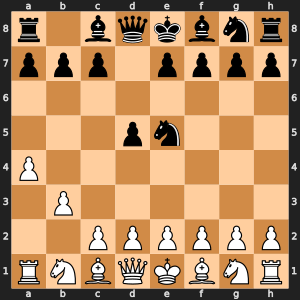

EVAL: 0.5740721821784973: -0.43981510400772095: f2f3: a1a2
f2f3
********************************* 



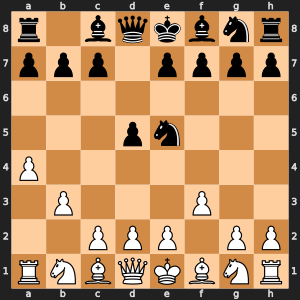

EVAL: -0.17912644147872925: -0.6807418465614319: e5f3: e8d7
e5f3
********************************* 



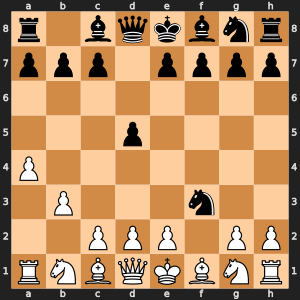

EVAL: 1.413661241531372: -0.4726100564002991: e2f3: e2f3
e2f3
********************************* 



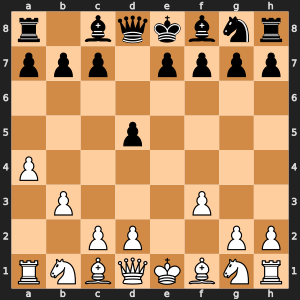

EVAL: 1.1526777744293213: -0.6478248238563538: c8d7: e8d7
c8d7
********************************* 



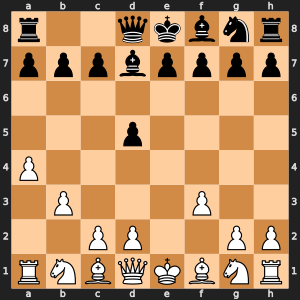

EVAL: 1.4453909397125244: -0.4375796914100647: h2h4: a1a2
h2h4
********************************* 



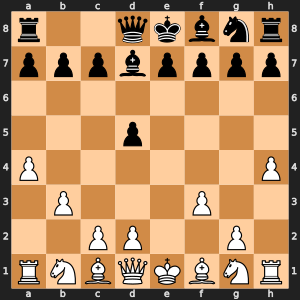

EVAL: 1.284038782119751: -0.704097330570221: f7f6: d8b8
f7f6
********************************* 



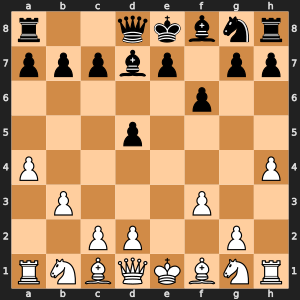

EVAL: 1.7301676273345947: -0.4493609070777893: d2d4: a1a2
d2d4
********************************* 



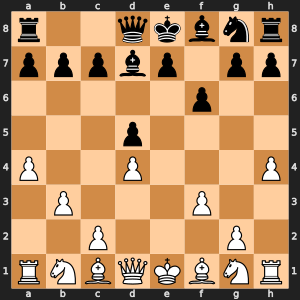

EVAL: 1.084407091140747: -0.8660455346107483: d7a4: e8f7
d7a4
********************************* 



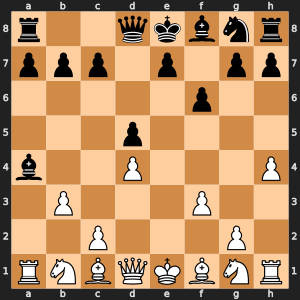

EVAL: 2.167699098587036: -0.3872447609901428: b3a4: h1h2
b3a4
********************************* 



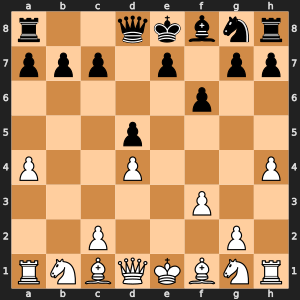

EVAL: 1.823106050491333: -0.8139587044715881: e7e5: e8f7
e7e5
********************************* 



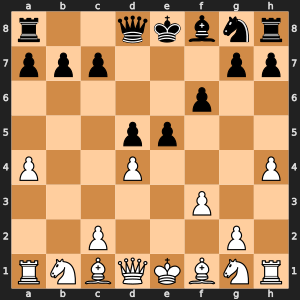

EVAL: 2.8321421146392822: -0.3462391495704651: d4e5: a1a2
d4e5
********************************* 



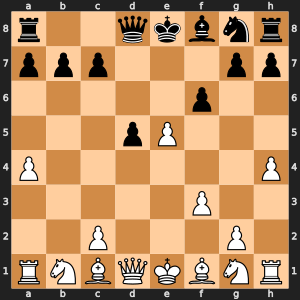

EVAL: 1.8459503650665283: -0.8025460839271545: f6e5: e8f7
f6e5
********************************* 



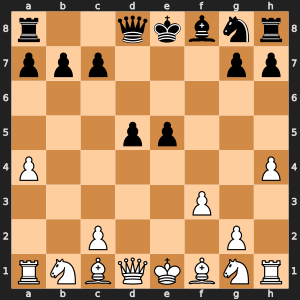

EVAL: 2.3696558475494385: -0.33788973093032837: b1d2: a1a2
b1d2
********************************* 



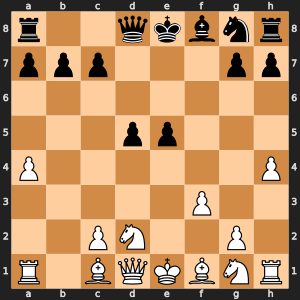

EVAL: 1.992401361465454: -0.7894101738929749: a8c8: e8f7
a8c8
********************************* 



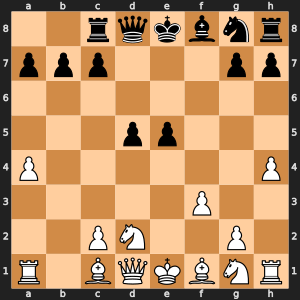

EVAL: 2.526789903640747: -0.40156370401382446: d2e4: a1a2
d2e4
********************************* 



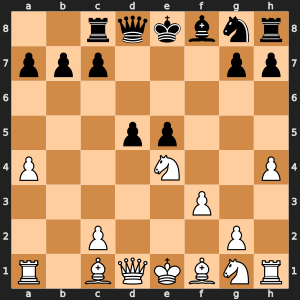

EVAL: 1.178565263748169: -0.7919097542762756: d5e4: e8f7
d5e4
********************************* 



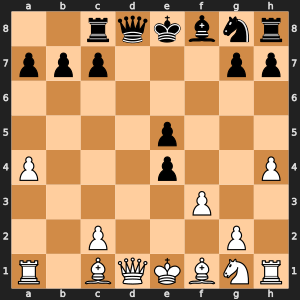

EVAL: 10.787678718566895: -0.4248247742652893: d1d8: a1a2
d1d8
********************************* 



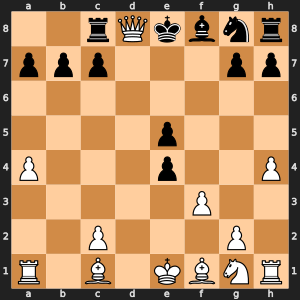

EVAL: -0.8240563273429871: -1.4008232355117798: c8d8: e8f7
c8d8
********************************* 



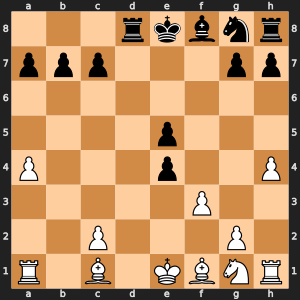

EVAL: 0.21932822465896606: -0.4073396325111389: c1e3: a1a2
c1e3
********************************* 



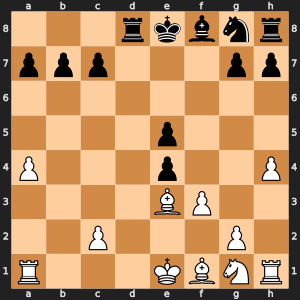

EVAL: -0.3448588252067566: -0.6312785744667053: f8e7: e8f7
f8e7
********************************* 



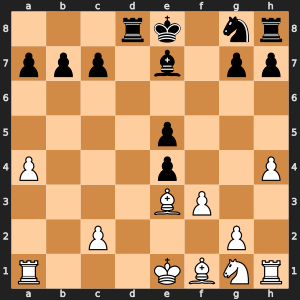

EVAL: 1.5301544666290283: -0.415748655796051: a1d1: a1c1
a1d1
********************************* 



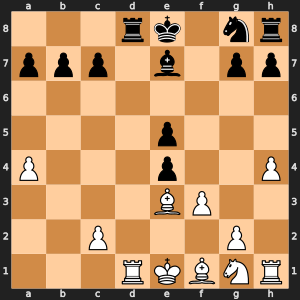

EVAL: -2.79724383354187: -0.6411414742469788: d8d1: e8f7
d8d1
********************************* 



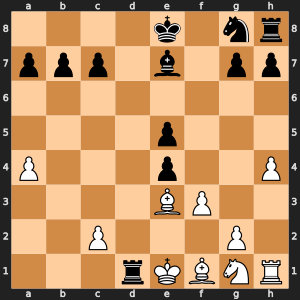

EVAL: 0.6275666356086731: -0.4867268204689026: e1d1: e1d1
e1d1
********************************* 



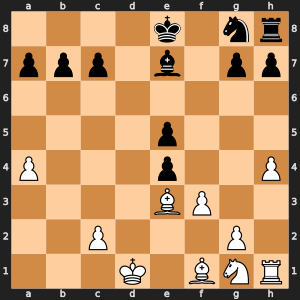

EVAL: -1.3935706615447998: -0.5491719841957092: e7d8: e7d6
e7d8
********************************* 



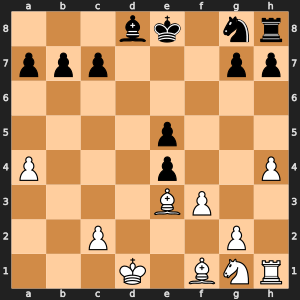

EVAL: 0.26289016008377075: -0.3413448929786682: e3c1: d1e1
e3c1
********************************* 



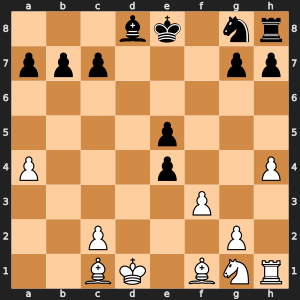

EVAL: -0.38554590940475464: -0.569186270236969: e4f3: e8f7
e4f3
********************************* 



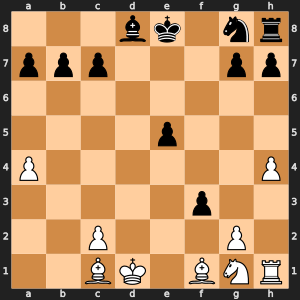

EVAL: 0.18586379289627075: -0.3744507431983948: g2f3: f1d3
g2f3
********************************* 



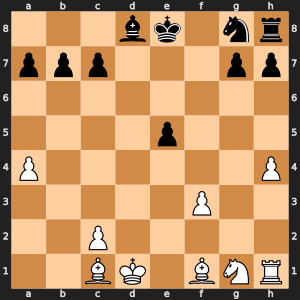

EVAL: -0.13449543714523315: -0.5797443985939026: h7h6: e8f7
h7h6
********************************* 



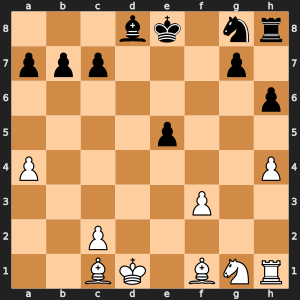

EVAL: 0.5352728962898254: -0.32654958963394165: d1e1: f1g2
d1e1
********************************* 



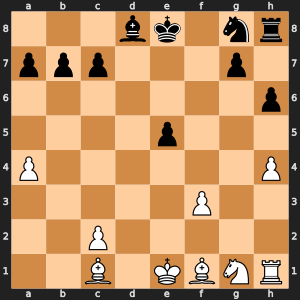

EVAL: 0.14529067277908325: -0.5442324280738831: b7b6: e8e7
b7b6
********************************* 



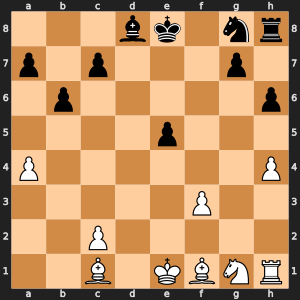

EVAL: 0.24361640214920044: -0.25631290674209595: c1g5: e1f2
c1g5
********************************* 



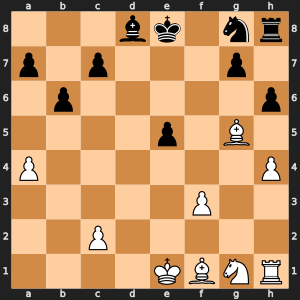

EVAL: -2.223358392715454: -0.45542293787002563: h6g5: h6g5
h6g5
********************************* 



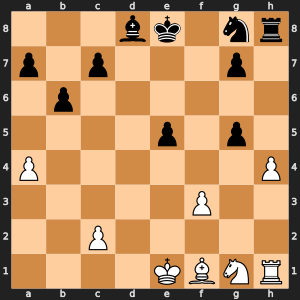

EVAL: -1.2962148189544678: -0.28300243616104126: h4g5: f1h3
h4g5
********************************* 



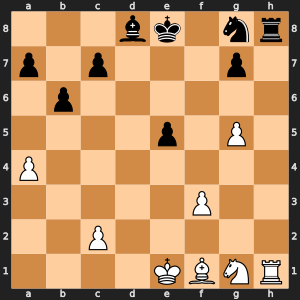

EVAL: -3.9523441791534424: -0.5115976929664612: h8h1: h8h3
h8h1
********************************* 



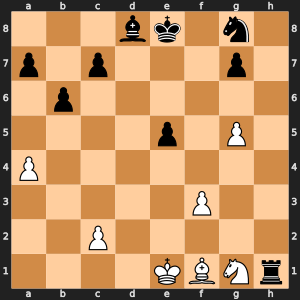

EVAL: -3.673570394515991: -0.3742557168006897: f1g2: f1h3
f1g2
********************************* 



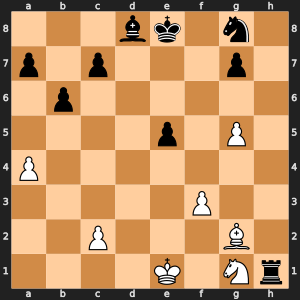

EVAL: -30.05455780029297: -0.9694977402687073: h1g1: h1g1
h1g1
********************************* 



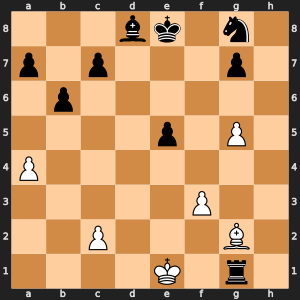

EVAL: -24.748367309570312: 0.5003916621208191: g2f1: e1d2
g2f1
********************************* 



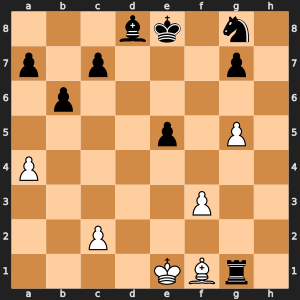

EVAL: -26.384166717529297: -1.4296263456344604: c7c6: d8g5
c7c6
********************************* 



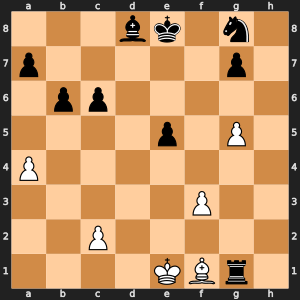

EVAL: -26.274612426757812: 0.06265132129192352: f3f4: e1d2
f3f4
********************************* 



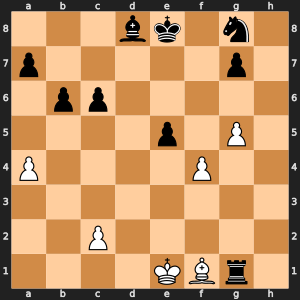

EVAL: -29.478534698486328: -1.4568811655044556: e5f4: d8g5
e5f4
********************************* 



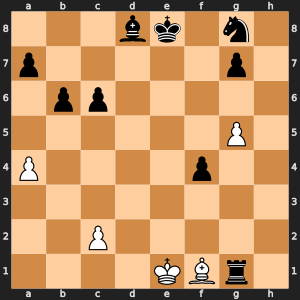

EVAL: -29.095705032348633: -1.1058402061462402: g5g6: e1d1
g5g6
********************************* 



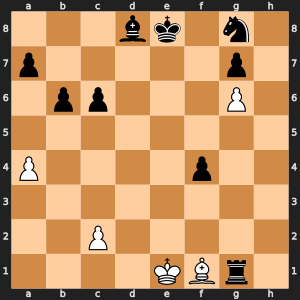

EVAL: -29.9405460357666: -1.5833138227462769: b6b5: f4f3
b6b5
********************************* 



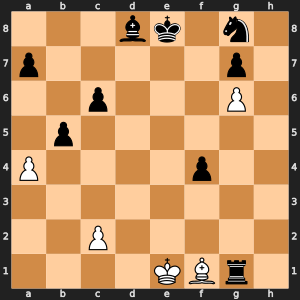

EVAL: -27.599952697753906: -1.2033535242080688: a4b5: e1d1
a4b5
********************************* 



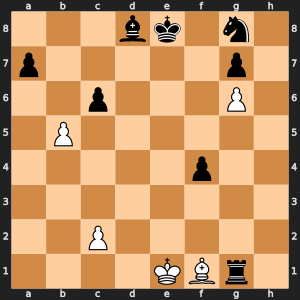

EVAL: -28.644763946533203: -1.4268742799758911: c6b5: d8g5
c6b5
********************************* 



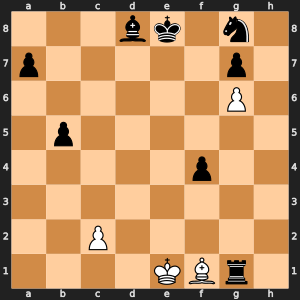

EVAL: -28.58877182006836: -1.3058172464370728: c2c4: e1d2
c2c4
********************************* 



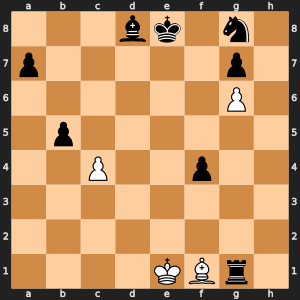

EVAL: -33.56275939941406: -1.6112638711929321: b5c4: f4f3
b5c4
********************************* 



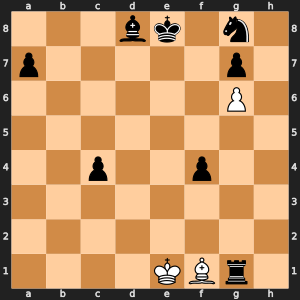

EVAL: -39.05363845825195: -0.3453696370124817: e1e2: e1d1
e1e2
********************************* 



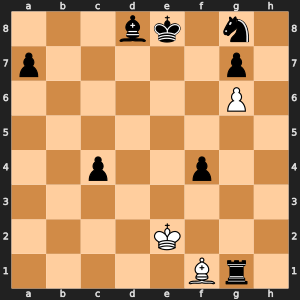

EVAL: -65.25504302978516: -10.660365104675293: g1f1: e8d7
BEST WAS CHECK IN X MOVES
e8d7
********************************* 



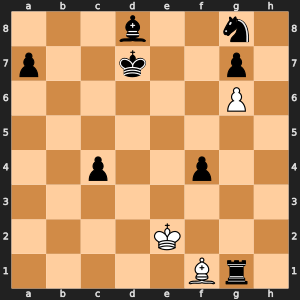

EVAL: -15.192193984985352: -1.1735764741897583: f1h3: e2e1
f1h3
********************************* 



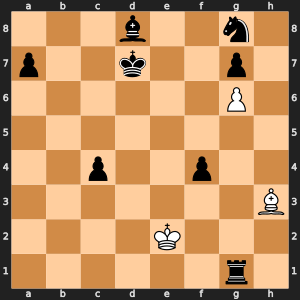

EVAL: -42.90199279785156: -11.102185249328613: d7d6: d7e8
BEST WAS CHECK IN X MOVES
d7e8
********************************* 



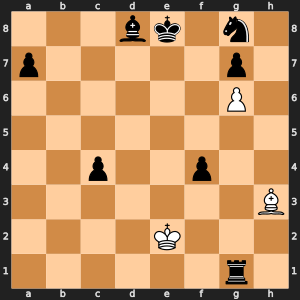

EVAL: -31.722972869873047: -7.777584075927734: h3e6: h3d7
BEST WAS CHECK IN X MOVES
h3d7
********************************* 



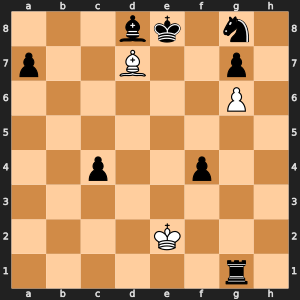

EVAL: -63.6366081237793: -15.876452445983887: e8f8: e8d7
BEST WAS CHECK IN X MOVES
e8d7
********************************* 



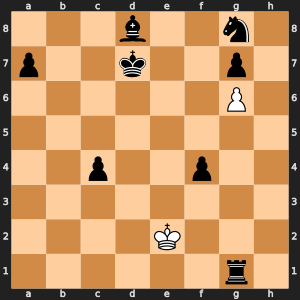

EVAL: -13.893622398376465: -13.032769203186035: e2f2: e2f3
BEST WAS CHECK IN X MOVES
e2f3
********************************* 



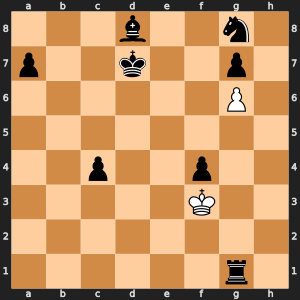

EVAL: -35.84029006958008: -13.2447509765625: g1e1: a7a5
BEST WAS CHECK IN X MOVES
a7a5
********************************* 



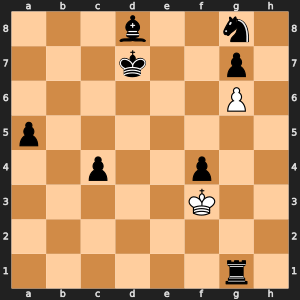

EVAL: -7.054214954376221: -15.797276496887207: f3e4: f3f2
BEST WAS CHECK IN X MOVES
f3f2
********************************* 



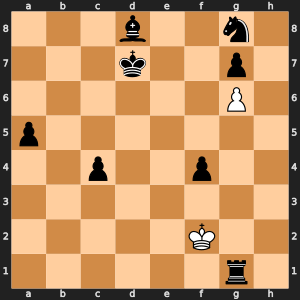

EVAL: -41.52737045288086: -16.466249465942383: g1a1: d7d6
BEST WAS CHECK IN X MOVES
d7d6
********************************* 



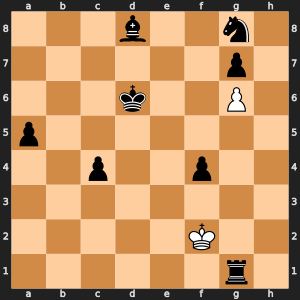

EVAL: -0.996844470500946: -0.3270459771156311: f2g1: f2g1
f2g1
********************************* 



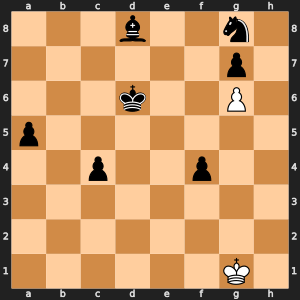

EVAL: -1.482818841934204: -0.3223586678504944: c4c3: f4f3
c4c3
********************************* 



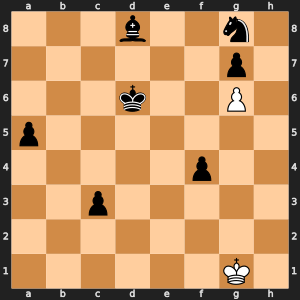

EVAL: -12.195869445800781: -0.861492931842804: g1h1: g1g2
g1h1
********************************* 



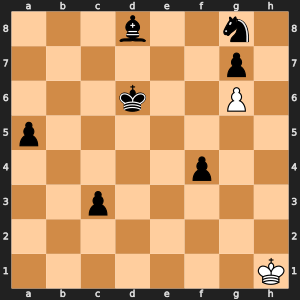

EVAL: -12.810867309570312: -1.6718953847885132: f4f3: f4f3
f4f3
********************************* 



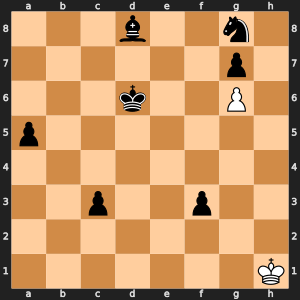

EVAL: -1.4732682704925537: -0.3059154152870178: h1g1: h1g1
h1g1
********************************* 



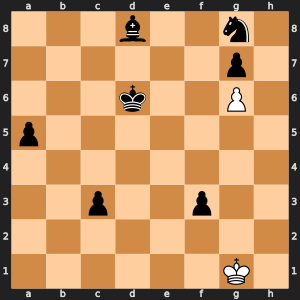

EVAL: -2.1094419956207275: -0.32629162073135376: d6e6: f3f2
d6e6
********************************* 



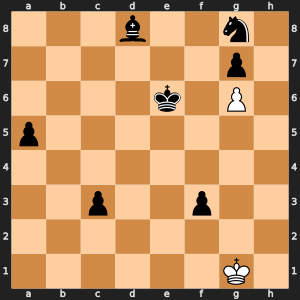

EVAL: -13.01784896850586: -0.9089758992195129: g1h1: g1f1
g1h1
********************************* 



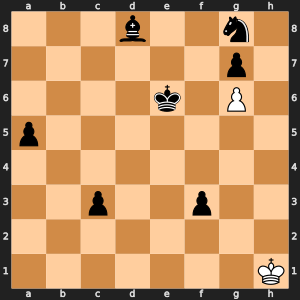

EVAL: -14.506145477294922: -1.6718953847885132: e6f6: e6d6
e6f6
********************************* 



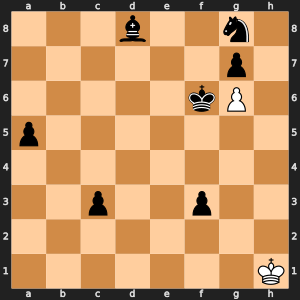

EVAL: -3.5825793743133545: -0.2683172821998596: h1g1: h1g1
h1g1
********************************* 



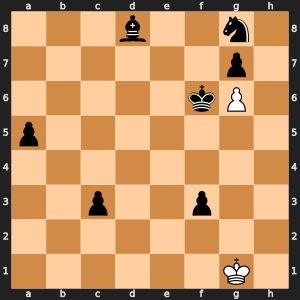

EVAL: -3.5918357372283936: -0.3519187569618225: a5a4: f6f5
a5a4
********************************* 



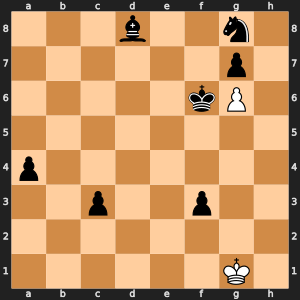

EVAL: -14.823221206665039: -0.5074771046638489: g1h1: g1f2
g1h1
********************************* 



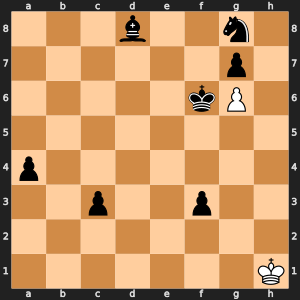

EVAL: -14.992929458618164: -1.5309638977050781: a4a3: f6f5
a4a3
********************************* 



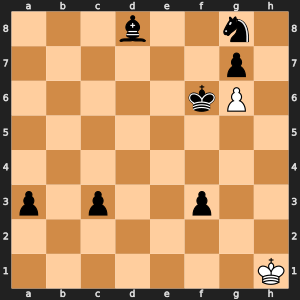

EVAL: -3.652170419692993: -0.2119971066713333: h1g1: h1g1
h1g1
********************************* 



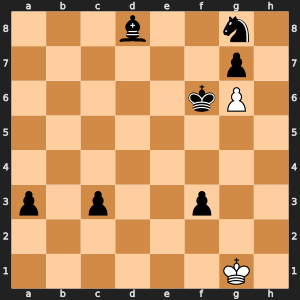

EVAL: -3.607274293899536: -0.3170471787452698: a3a2: f6f5
a3a2
********************************* 



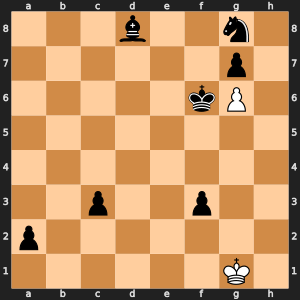

EVAL: -15.511402130126953: -0.587240993976593: g1h1: g1f2
g1h1
********************************* 



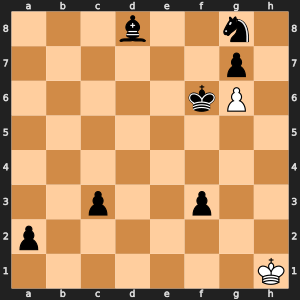

EVAL: -41.1519775390625: -3.613800048828125: a2a1r: a2a1q
a2a1r
********************************* 



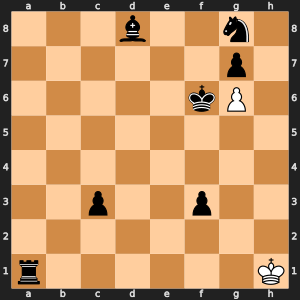

EVAL: -46.1317253112793: -3.255056381225586: h1h2: h1h2
h1h2
********************************* 



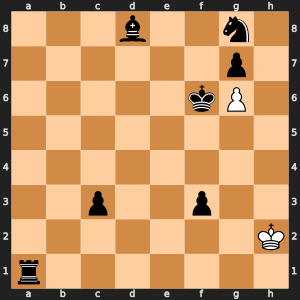

EVAL: -61.134037017822266: -12.032767295837402: g8h6: f6g6
BEST WAS CHECK IN X MOVES
f6g6
********************************* 



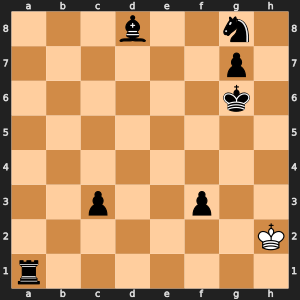

EVAL: -9.33005142211914: -14.752622604370117: h2g3: h2g3
BEST WAS CHECK IN X MOVES
h2g3
********************************* 



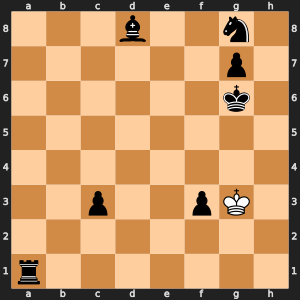

EVAL: -28.393230438232422: -18.696767807006836: g6f7: a1g1
BEST WAS CHECK IN X MOVES
a1g1
********************************* 



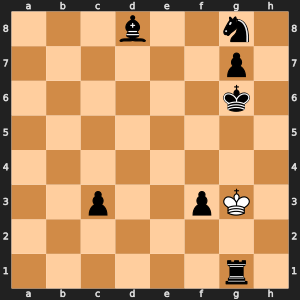

EVAL: -1.4279215335845947: -14.910526275634766: g3f2: g3f3
BEST WAS CHECK IN X MOVES
g3f3
********************************* 



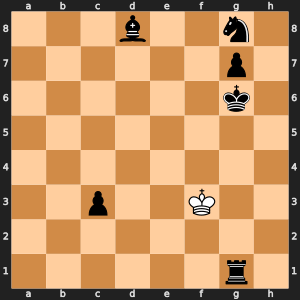

EVAL: -42.888248443603516: -15.639555931091309: g1f1: c3c2
BEST WAS CHECK IN X MOVES
c3c2
********************************* 



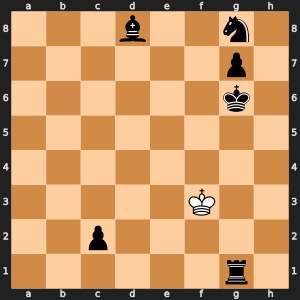

EVAL: 1.9407265186309814: -15.56049633026123: f3f2: f3e3
BEST WAS CHECK IN X MOVES
f3e3
********************************* 



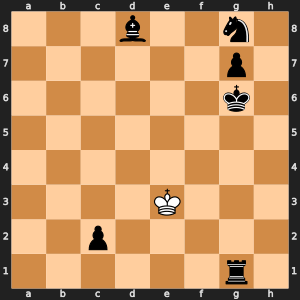

EVAL: -27.890058517456055: -19.98553466796875: g6h7: c2c1q
BEST WAS CHECK IN X MOVES
c2c1q
********************************* 



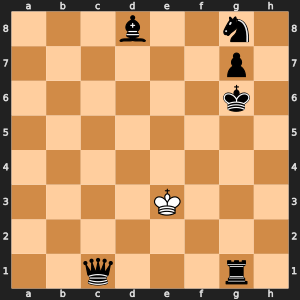

EVAL: 7.218726634979248: -19.826597213745117: e3f2: e3f3
BEST WAS CHECK IN X MOVES
e3f3
********************************* 



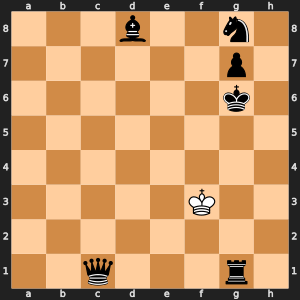

EVAL: -24.4830322265625: -24.58030891418457: c1c7: c1e1
BEST WAS CHECK IN X MOVES
c1e1
********************************* 



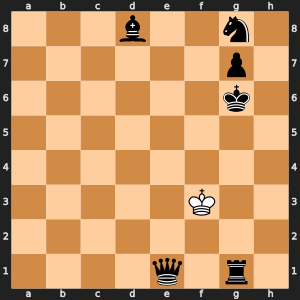

EVAL: -6.2469258308410645: -26.029890060424805: f3f4: f3f4
BEST WAS CHECK IN X MOVES
f3f4
********************************* 



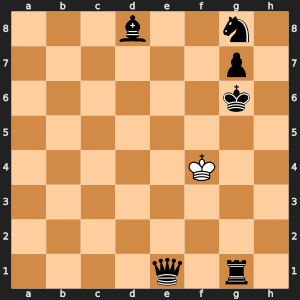

EVAL: -33.77757263183594: -26.12613868713379: g6f6: d8b6
BEST WAS CHECK IN X MOVES
d8b6
********************************* 



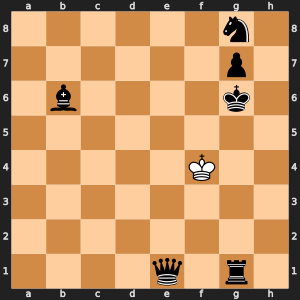

EVAL: 3.7441160678863525: -24.742319107055664: f4f3: f4f3
BEST WAS CHECK IN X MOVES
f4f3
********************************* 



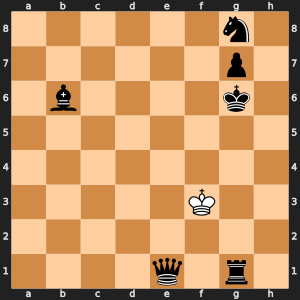

EVAL: -15.951940536499023: -24.58030891418457: e1e8: b6d8
BEST WAS CHECK IN X MOVES
b6d8
********************************* 



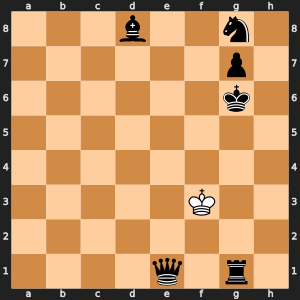

EVAL: -6.2469258308410645: -26.029890060424805: f3f4: f3f4
BEST WAS CHECK IN X MOVES
f3f4
********************************* 



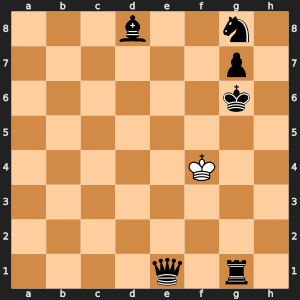

EVAL: -33.77757263183594: -26.12613868713379: g6f6: d8b6
BEST WAS CHECK IN X MOVES
d8b6
********************************* 



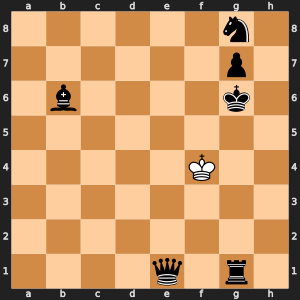

EVAL: 3.7441160678863525: -24.742319107055664: f4f3: f4f3
BEST WAS CHECK IN X MOVES
f4f3
********************************* 



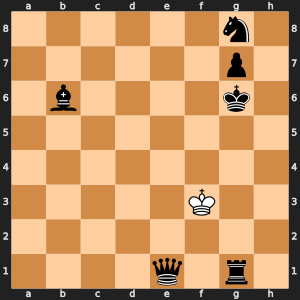

EVAL: -15.951940536499023: -24.58030891418457: e1e8: b6d8
BEST WAS CHECK IN X MOVES
b6d8
********************************* 



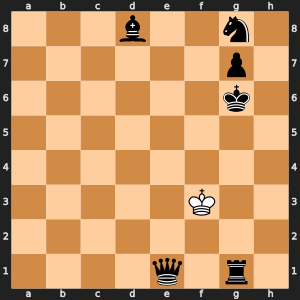

EVAL: -6.2469258308410645: -26.029890060424805: f3f4: f3f4
BEST WAS CHECK IN X MOVES
f3f4
********************************* 



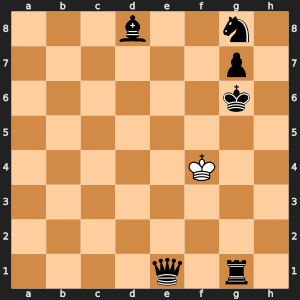

EVAL: -33.77757263183594: -26.12613868713379: g6f6: d8b6
BEST WAS CHECK IN X MOVES
d8b6
********************************* 



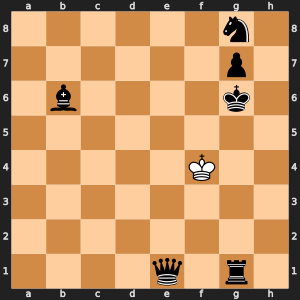

EVAL: 3.7441160678863525: -24.742319107055664: f4f3: f4f3
BEST WAS CHECK IN X MOVES
f4f3
********************************* 



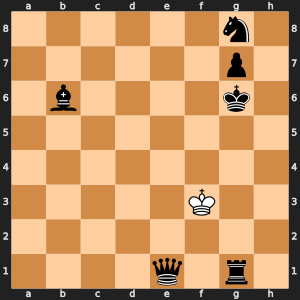

EVAL: -15.951940536499023: -24.58030891418457: e1e8: b6d8
BEST WAS CHECK IN X MOVES
b6d8
********************************* 



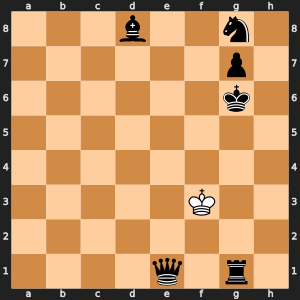

EVAL: -6.2469258308410645: -26.029890060424805: f3f4: f3f4
BEST WAS CHECK IN X MOVES
f3f4
********************************* 



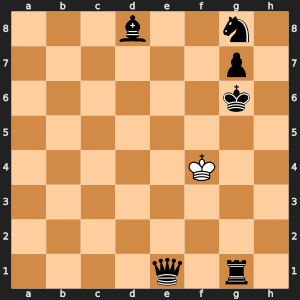

EVAL: -33.77757263183594: -26.12613868713379: g6f6: d8b6
BEST WAS CHECK IN X MOVES
d8b6
********************************* 



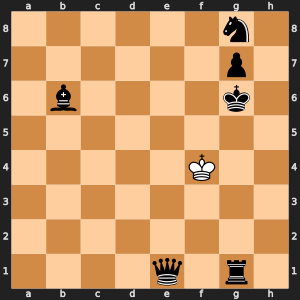

EVAL: 3.7441160678863525: -24.742319107055664: f4f3: f4f3
BEST WAS CHECK IN X MOVES
f4f3
********************************* 



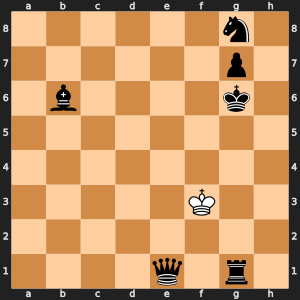

EVAL: -15.951940536499023: -24.58030891418457: e1e8: b6d8
BEST WAS CHECK IN X MOVES
b6d8
********************************* 



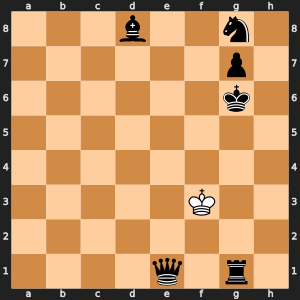

Game Over
Result:  1/2-1/2
[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "1/2-1/2"]

1. a3 d5 2. b3 Nc6 3. a4 Ne5 4. f3 Nxf3+ 5. exf3 Bd7 6. h4 f6 7. d4 Bxa4 8. bxa4 e5 9. dxe5 fxe5 10. Nd2 Rc8 11. Ne4 dxe4 12. Qxd8+ Rxd8 13. Be3 Be7 14. Rd1 Rxd1+ 15. Kxd1 Bd8 16. Bc1 exf3 17. gxf3 h6 18. Ke1 b6 19. Bg5 hxg5 20. hxg5 Rxh1 21. Bg2 Rxg1+ 22. Bf1 c6 23. f4 exf4 24. g6 b5 25. axb5 cxb5 26. c4 bxc4 27. Ke2 Kd7 28. Bh3+ Ke8 29. Bd7+ Kxd7 30. Kf3 a5 31. Kf2 Kd6 32. Kxg1 c3 33. Kh1 f3 34. Kg1 Ke6 35. Kh1 Kf6 36. Kg1 a4 37. Kh1 a3 38. Kg1 a2 39. Kh1 a1=R+ 40. Kh2 Kxg6 41. Kg3 Rg1+ 42. Kxf3 c2 43. Ke3 c1=Q+ 44. Kf3 Qe1 45. Kf4 Bb6 46. Kf3 Bd8 47. Kf4 Bb6 48. Kf3 Bd8 49. Kf4 Bb6 50. Kf3 Bd8 51. Kf4 Bb6 52. Kf3 Bd8 1/2-1/2


In [79]:
import chess
import chess.svg
import torch
import torch.nn as nn
from IPython.display import SVG, display

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a function to convert the board state into a format suitable for input to the neural network
def preprocess_board_state(board):
    board_state = [(((board.piece_at(square).piece_type * (1 if board.piece_at(square).color else -1))) if board.piece_at(square) is not None else 0) for square in chess.SQUARES]
    return torch.tensor(board_state, dtype=torch.float32).to(device)

# Define a function to generate legal moves for the current player
def generate_legal_moves(board):
    legal_moves = []
    for move in board.legal_moves:
        legal_moves.append(move)
    return legal_moves

# Evaluate each legal move using the neural network model and select the move with the highest evaluation
def select_best_move(board, legal_moves, model):
    whitePlays = board.turn
    best_move = None
    best_check_in_move = None
    best_eval = float('-inf') if board.turn else float('inf')  # Initialize best evaluation based on player's perspective
    best_check_in = float('-inf') if board.turn else float('inf')  # Initialize best check_in based on player's perspective

    for move in legal_moves:
        board.push(move)
        board_state = preprocess_board_state(board)
        eval_output, check_in_output = model(board_state)

        # Assuming 'eval_output' contains the evaluation for the current player's perspective
        eval_value = eval_output.item()
        check_in_value = check_in_output.item()

        if whitePlays:  # Maximizing player
            if eval_value > best_eval:
                best_eval = eval_value
                best_move = move
            if check_in_value > best_check_in:
                best_check_in = check_in_value
                best_check_in_move = move
        else:  # Minimizing player
            if eval_value < best_eval:
                best_eval = eval_value
                best_move = move
            if check_in_value < best_check_in:
                best_check_in = check_in_value
                best_check_in_move = move

        board.pop()
    print(f"EVAL: {best_eval}: {best_check_in}: {best_move}: {best_check_in_move}")
    if abs(best_check_in) >= 5:
      print("BEST WAS CHECK IN X MOVES")
      return best_check_in_move
    else:
      return best_move

# Play a game of chess using the model
def play_game(model):
    board = chess.Board()
    moves = []
    while not board.is_game_over():
        if board.is_checkmate() or board.is_stalemate() or board.is_insufficient_material() or board.is_seventyfive_moves():
            print("Game Over")
            print("Result: ", board.result())
            return

        legal_moves = generate_legal_moves(board)
        if len(legal_moves) == 0:
            print("Game Over - No legal moves left")
            print("Result: ", board.result())
            return

        best_move = select_best_move(board, legal_moves, model)
        print(best_move)
        board.push(best_move)
        moves.append(best_move)
        print("*********************************", "\n")
        display(SVG(chess.svg.board(board,size=300)))

    # Print the final result of the game
    print("Game Over")
    print("Result: ", board.result())
    print(generate_pgn(board, moves))  # Generate and print the PGN

# Example usage:
# Assuming 'model' is your trained neural network model
play_game(model.to(device))  # Move the model to GPU if available


In [48]:
print(board)

R . . . . . . .
. . . . . . p p
. . . . . k . .
. . . . . . . .
P . K P . . . .
. . P . r . . P
. . . . . . . .
. . . . . . . .
